In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, "/notebooks/")
from fastai.imports import *

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(-1)

In [3]:
f_model=resnet34
sz=224
bs=64

In [4]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+20),
)
model = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
# learn = ConvLearner(md, models)
# learn.opt_fn = optim.Adam

In [5]:
model = model.model

In [6]:
file_path = "/notebooks/data/pascal/models/pascal_v2_cpu.h5"

In [7]:
state_dict = torch.load(file_path, map_location=lambda storage, loc: storage)

In [8]:
model.load_state_dict(state_dict), model.eval()

(None, Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
   (4): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (relu): ReLU(inplace)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
       (relu): ReLU(inplace)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [9]:
import cv2
import urllib
def open_image_url(url):
	"""  Opens an image using OpenCV from a URL.
	:param url: url path of the image
	:return: the image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
	"""
	flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
	url = str(url)
	resp = urllib.request.urlopen(url)
	try:
		im = np.asarray(bytearray(resp.read()))
		im = cv2.imdecode(im, flags).astype(np.float32)/255
		if im is None: raise OSError(f'File from url not recognized by opencv: {url}')
		return im
	except Exception as e:
		raise OSError(f'Error handling image from url at: {url}') from e

In [10]:
def open_image(path):
	""" Opens an image using OpenCV given the file path.
	:param path: the file path of the image
	:return: the image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
	"""
	flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
	path = str(path)
	if not os.path.exists(path):
		raise OSError(f'No such file or directory: {path}')
	elif os.path.isdir(path):
		raise OSError(f'Is a directory: {path}')
	else:
		try:
			im = cv2.imread(str(path), flags).astype(np.float32)/255
			if im is None: raise OSError(f'File not recognized by opencv: {path}')
			return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
		except Exception as e:
			raise OSError(f'Error handling image at: {path}') from e

In [11]:
url = "https://d1iguv6ee4dmhj.cloudfront.net/media/celeb/images/taylor_PtHK2mk.jpeg"

In [12]:
img = open_image_url(url)

In [39]:
STATS = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
SZ = 224
TFMS = tfms_from_stats(STATS, SZ)[-1]

def predict(img):
	batch = [T(TFMS(img), cuda=False)]
	inp = VV_(torch.stack(batch))
	return model(inp).mean(0)

In [40]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [41]:
im = open_image('/notebooks/data/pascal/taylor_Z9OYgQC.jpeg')

In [106]:
classes = ['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [107]:
out = predict(open_image_url(url))

In [108]:
out = out.cpu()

In [109]:
out = out.data.numpy()

In [110]:
bb, c = out[:4], out[4:]

In [111]:
from scipy.special import expit
bb = expit(bb)*224

In [112]:
bb

array([ 11.70317,  24.79585, 216.41632, 208.47272], dtype=float32)

In [113]:
c = np.argmax(c)

In [114]:
c

14

In [115]:
cname = classes[c]

In [116]:
cname

'person'

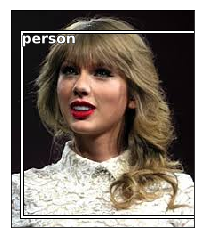

In [117]:
ax = show_img(im)
b = bb
draw_rect(ax, b)
draw_text(ax, b[:2], cname)